# Tasks Day 1 – Understanding your data

In [43]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import sent_tokenize

In [ ]:
# convert txt to csv
#!python ../utils/make_pubmed_csv.py convert-to-csv ../data/PubMed_200k_RCT/ ../data/PubMed_200k_RCT_tabular/

In [42]:
data_dir = Path('../data/')
drugsCom_train_path= data_dir / 'drugsCom_raw/drugsComTrain_raw.tsv'
drugsCom_test_path= data_dir / 'drugsCom_raw/drugsComTest_raw.tsv'
pubmed_path = data_dir / 'PubMed_200k_RCT_tabular/whole.csv'


## 1. Drug Review Dataset

In [25]:
drugsCom_train_df=pd.read_csv(drugsCom_train_path, sep='\t')
drugsCom_test_df=pd.read_csv(drugsCom_test_path, sep='\t')
drugsCom_df = pd.concat([drugsCom_train_df, drugsCom_test_df], axis=0)

In [26]:
drugsCom_df.rename(columns = {'Unnamed: 0':'id'}, inplace = True)
drugsCom_df.head(5)

id                  drugName                     condition  \
0  206461                 Valsartan  Left Ventricular Dysfunction   
1   95260                Guanfacine                          ADHD   
2   92703                    Lybrel                 Birth Control   
3  138000                Ortho Evra                 Birth Control   
4   35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37

Attribute Information:

1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful

In [27]:
# number of records
print("No. records:", len(drugsCom_df.index))

No. records: 215063


In [28]:
# missing values
drugsCom_df.isna().sum()

id                0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [29]:
drugsCom_df.condition[drugsCom_df.condition.notna() & drugsCom_df.condition.str.endswith("helpful.")]

105       2</span> users found this comment helpful.
196       4</span> users found this comment helpful.
243       3</span> users found this comment helpful.
264       4</span> users found this comment helpful.
391      11</span> users found this comment helpful.
                            ...                     
52443     3</span> users found this comment helpful.
53116     5</span> users found this comment helpful.
53287    21</span> users found this comment helpful.
53353    28</span> users found this comment helpful.
53570     5</span> users found this comment helpful.
Name: condition, Length: 1171, dtype: object

We found inconsistent entries in the column *condition*.

In [30]:
# set inconsistent entries as NaN
drugsCom_df.loc[drugsCom_df.condition.notna() & drugsCom_df.condition.str.endswith("helpful."), 'condition'] = np.nan

In [31]:
print("no. missing values", drugsCom_df.condition.isna().sum())
print("%missing values:", drugsCom_df.condition.isna().sum() / len(drugsCom_df.index) * 100)

no. missing values 2365
%missing values: 1.0996777688398285


We will delete them when analyzing *condition* column.

In [32]:
drugsCom_df_notna = drugsCom_df.dropna(axis=0)

### Categorical/Numerical feature distribution

Text(0, 0.5, 'Number of records')

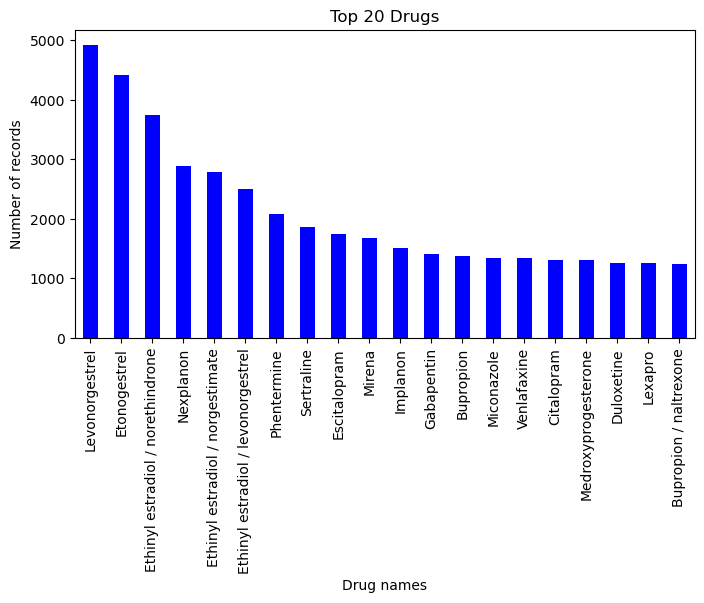

In [33]:
# What is the most popular drugs?
top_20_drug = drugsCom_df.drugName.value_counts().sort_values(ascending=False)[:20]
top_20_drug.plot(kind="bar", figsize = (8,4), color="blue")
plt.title("Top 20 Drugs")
plt.xlabel("Drug names")
plt.ylabel("Number of records")

Text(0, 0.5, 'Number of records')

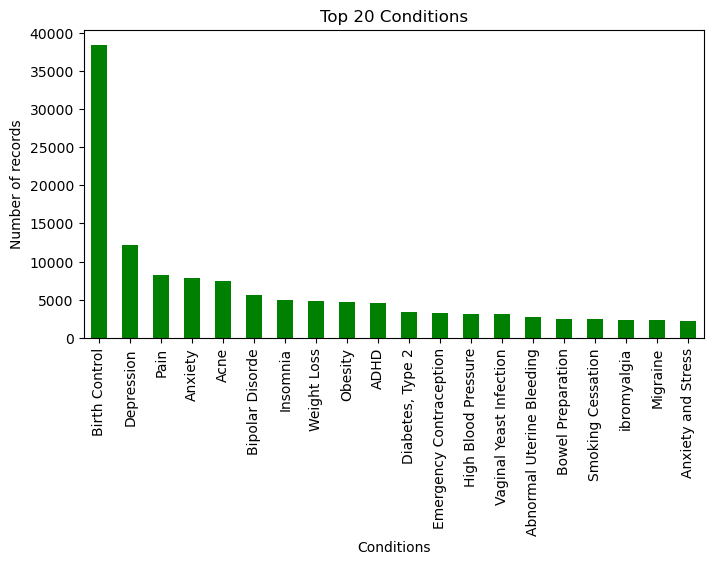

In [34]:
# What is the most popular conditions?
top_20_cond = drugsCom_df_notna.condition.value_counts().sort_values(ascending=False)[:20]
top_20_cond.plot(kind="bar", figsize = (8,4), color="green")
plt.title("Top 20 Conditions")
plt.xlabel("Conditions")
plt.ylabel("Number of records")

Text(0, 0.5, 'Number of records')

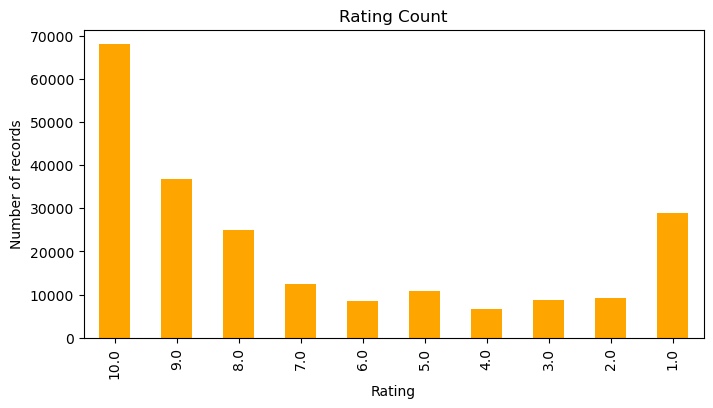

In [35]:
# Overall rating
rating = drugsCom_df.rating.value_counts().sort_index(ascending=False)
rating.plot(kind="bar", figsize = (8,4), color="orange")
plt.title("Rating Count")
plt.xlabel("Rating")
plt.ylabel("Number of records")

Text(0, 0.5, 'Number of records')

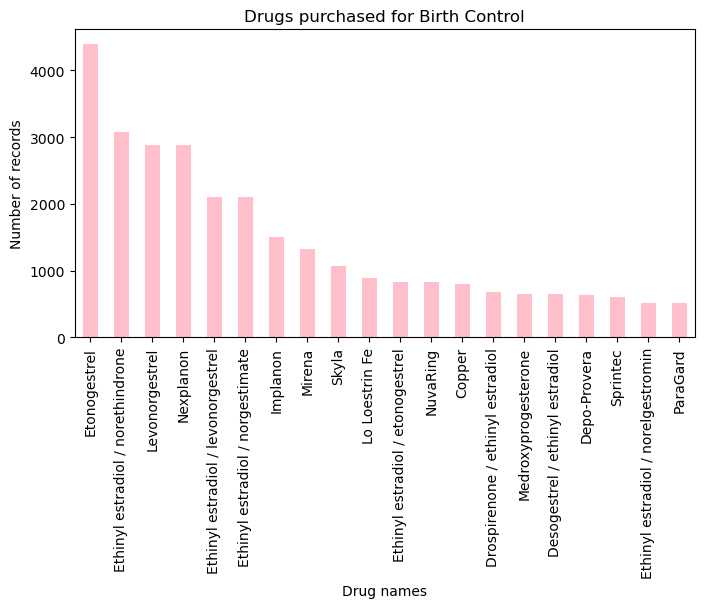

In [36]:
# What drugs are most popular for top condition?
cond = top_20_cond.index[0] # change index to explore more
drug_in_cond = drugsCom_df_notna.drugName[drugsCom_df_notna.condition==cond].value_counts().sort_values(ascending=False)[:20]
drug_in_cond.plot(kind="bar", figsize = (8,4), color="pink")
plt.title(f"Drugs purchased for {cond}")
plt.xlabel("Drug names")
plt.ylabel("Number of records")

Text(0, 0.5, 'Usefulness')

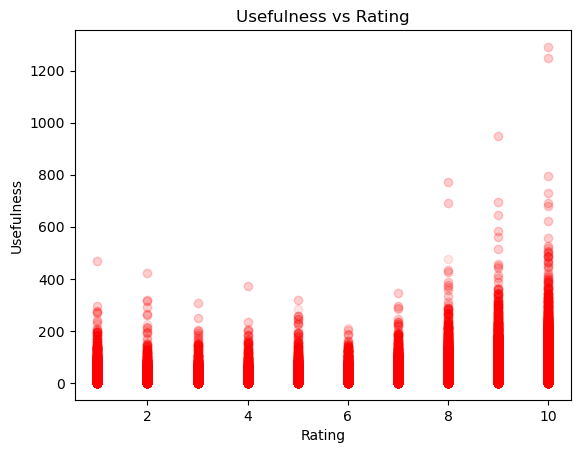

In [37]:
# What comments are most useful?
plt.scatter(drugsCom_df.rating, drugsCom_df.usefulCount, color="red", alpha=0.1)
plt.title("Usefulness vs Rating")
plt.xlabel('Rating')
plt.ylabel('Usefulness')

Text(0, 0.5, 'Number of records')

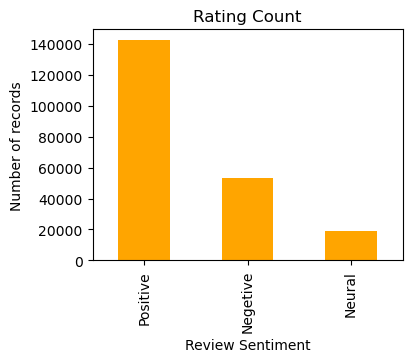

In [38]:
def rating_to_sentiment(x):
    if x > 6:
        return 2  # POSITIVE
    elif x < 5:
        return 0  # NEGATIVE
    else:
        return 1  # NEUTRAL

drugsCom_df['reviewSentiment'] = drugsCom_df.rating.map(rating_to_sentiment)

# Overall sentiment
sentiment = drugsCom_df.reviewSentiment.value_counts(ascending=False)
sentiment.rename(index={0: 'Negetive', 1: 'Neural', 2:'Positive'}, inplace=True)
sentiment.plot(kind="bar", figsize = (4,3), color="orange")
plt.title("Rating Count")
plt.xlabel("Review Sentiment")
plt.ylabel("Number of records")

## Textual feature distribution

Sentence detection

In [39]:
drugsCom_df['sentenceLength'] = drugsCom_df.review.map(lambda x: len(sent_tokenize(x)))
drugsCom_df.head(5)

id                  drugName                     condition  \
0  206461                 Valsartan  Left Ventricular Dysfunction   
1   95260                Guanfacine                          ADHD   
2   92703                    Lybrel                 Birth Control   
3  138000                Ortho Evra                 Birth Control   
4   35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  reviewSentiment  sentenceLength  
0       May 20, 2012           27                2               1  
1     April 27, 2010          192                2              11  
2  December 14, 2009           17                1               9  
3   November 3, 2015           10                2               5  
4  November 27, 2016           37                2              11

In [41]:
print('max. sentence length:', drugsCom_df.sentenceLength.max())
print('min. sentence length:', drugsCom_df.sentenceLength.min())

max. sentence length: 92
min. sentence length: 1


Word Cloud

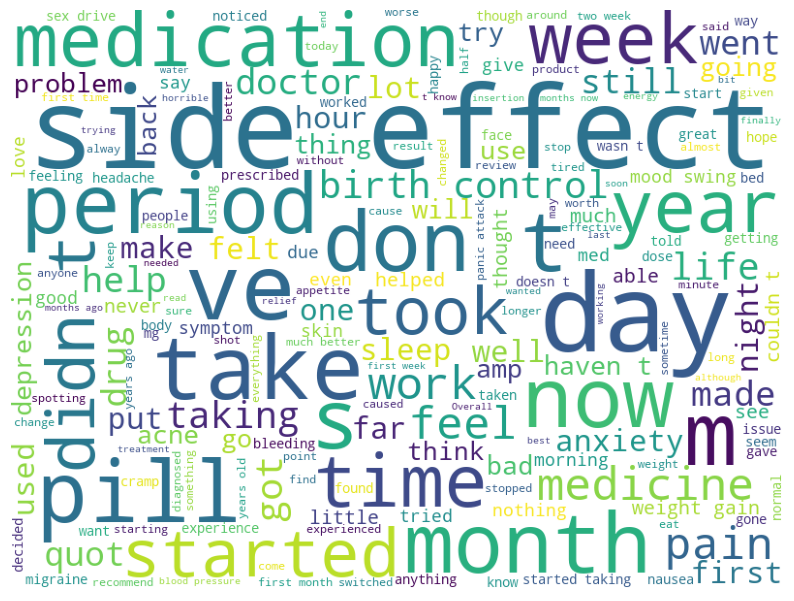

In [40]:
text = '. '.join(drugsCom_df.review.tolist())
wordcloud = WordCloud(width = 800, height = 600, stopwords=STOPWORDS, background_color="white").generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 3. PubMed 200k RCT Dataset - Training Set

In [45]:
pubmed_df = pd.read_csv(pubmed_path)
pubmed_df.head(5)

sentence       label
0  Adrenergic activation is thought to be an impo...  BACKGROUND
1  Systemic venous norepinephrine was measured at...     RESULTS
2  Baseline norepinephrine level was associated w...     RESULTS
3  On multivariate analysis , baseline norepineph...     RESULTS
4  In contrast , the relation of the change in no...     RESULTS

In [46]:
# missing values
pubmed_df.isna().sum()

sentence    0
label       0
dtype: int64

Label Distribution

<Axes: >

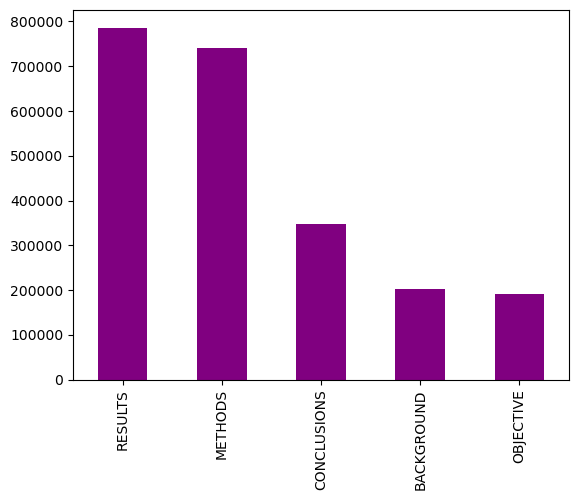

In [48]:
pubmed_df.label.value_counts(ascending=False).plot(kind='bar', color='purple')

Sentence Detection

In [50]:
pubmed_df['sentenceLength'] = pubmed_df.sentence.map(lambda x: len(sent_tokenize(x)))
pubmed_df.head(5)

sentence       label  \
0  Adrenergic activation is thought to be an impo...  BACKGROUND   
1  Systemic venous norepinephrine was measured at...     RESULTS   
2  Baseline norepinephrine level was associated w...     RESULTS   
3  On multivariate analysis , baseline norepineph...     RESULTS   
4  In contrast , the relation of the change in no...     RESULTS   

   sentenceLength  
0               1  
1               1  
2               1  
3               1  
4               1

In [52]:
print('max. sentence length:', pubmed_df.sentenceLength.max())
print('min. sentence length:', pubmed_df.sentenceLength.min())

max. sentence length: 15
min. sentence length: 1


Wordclouds

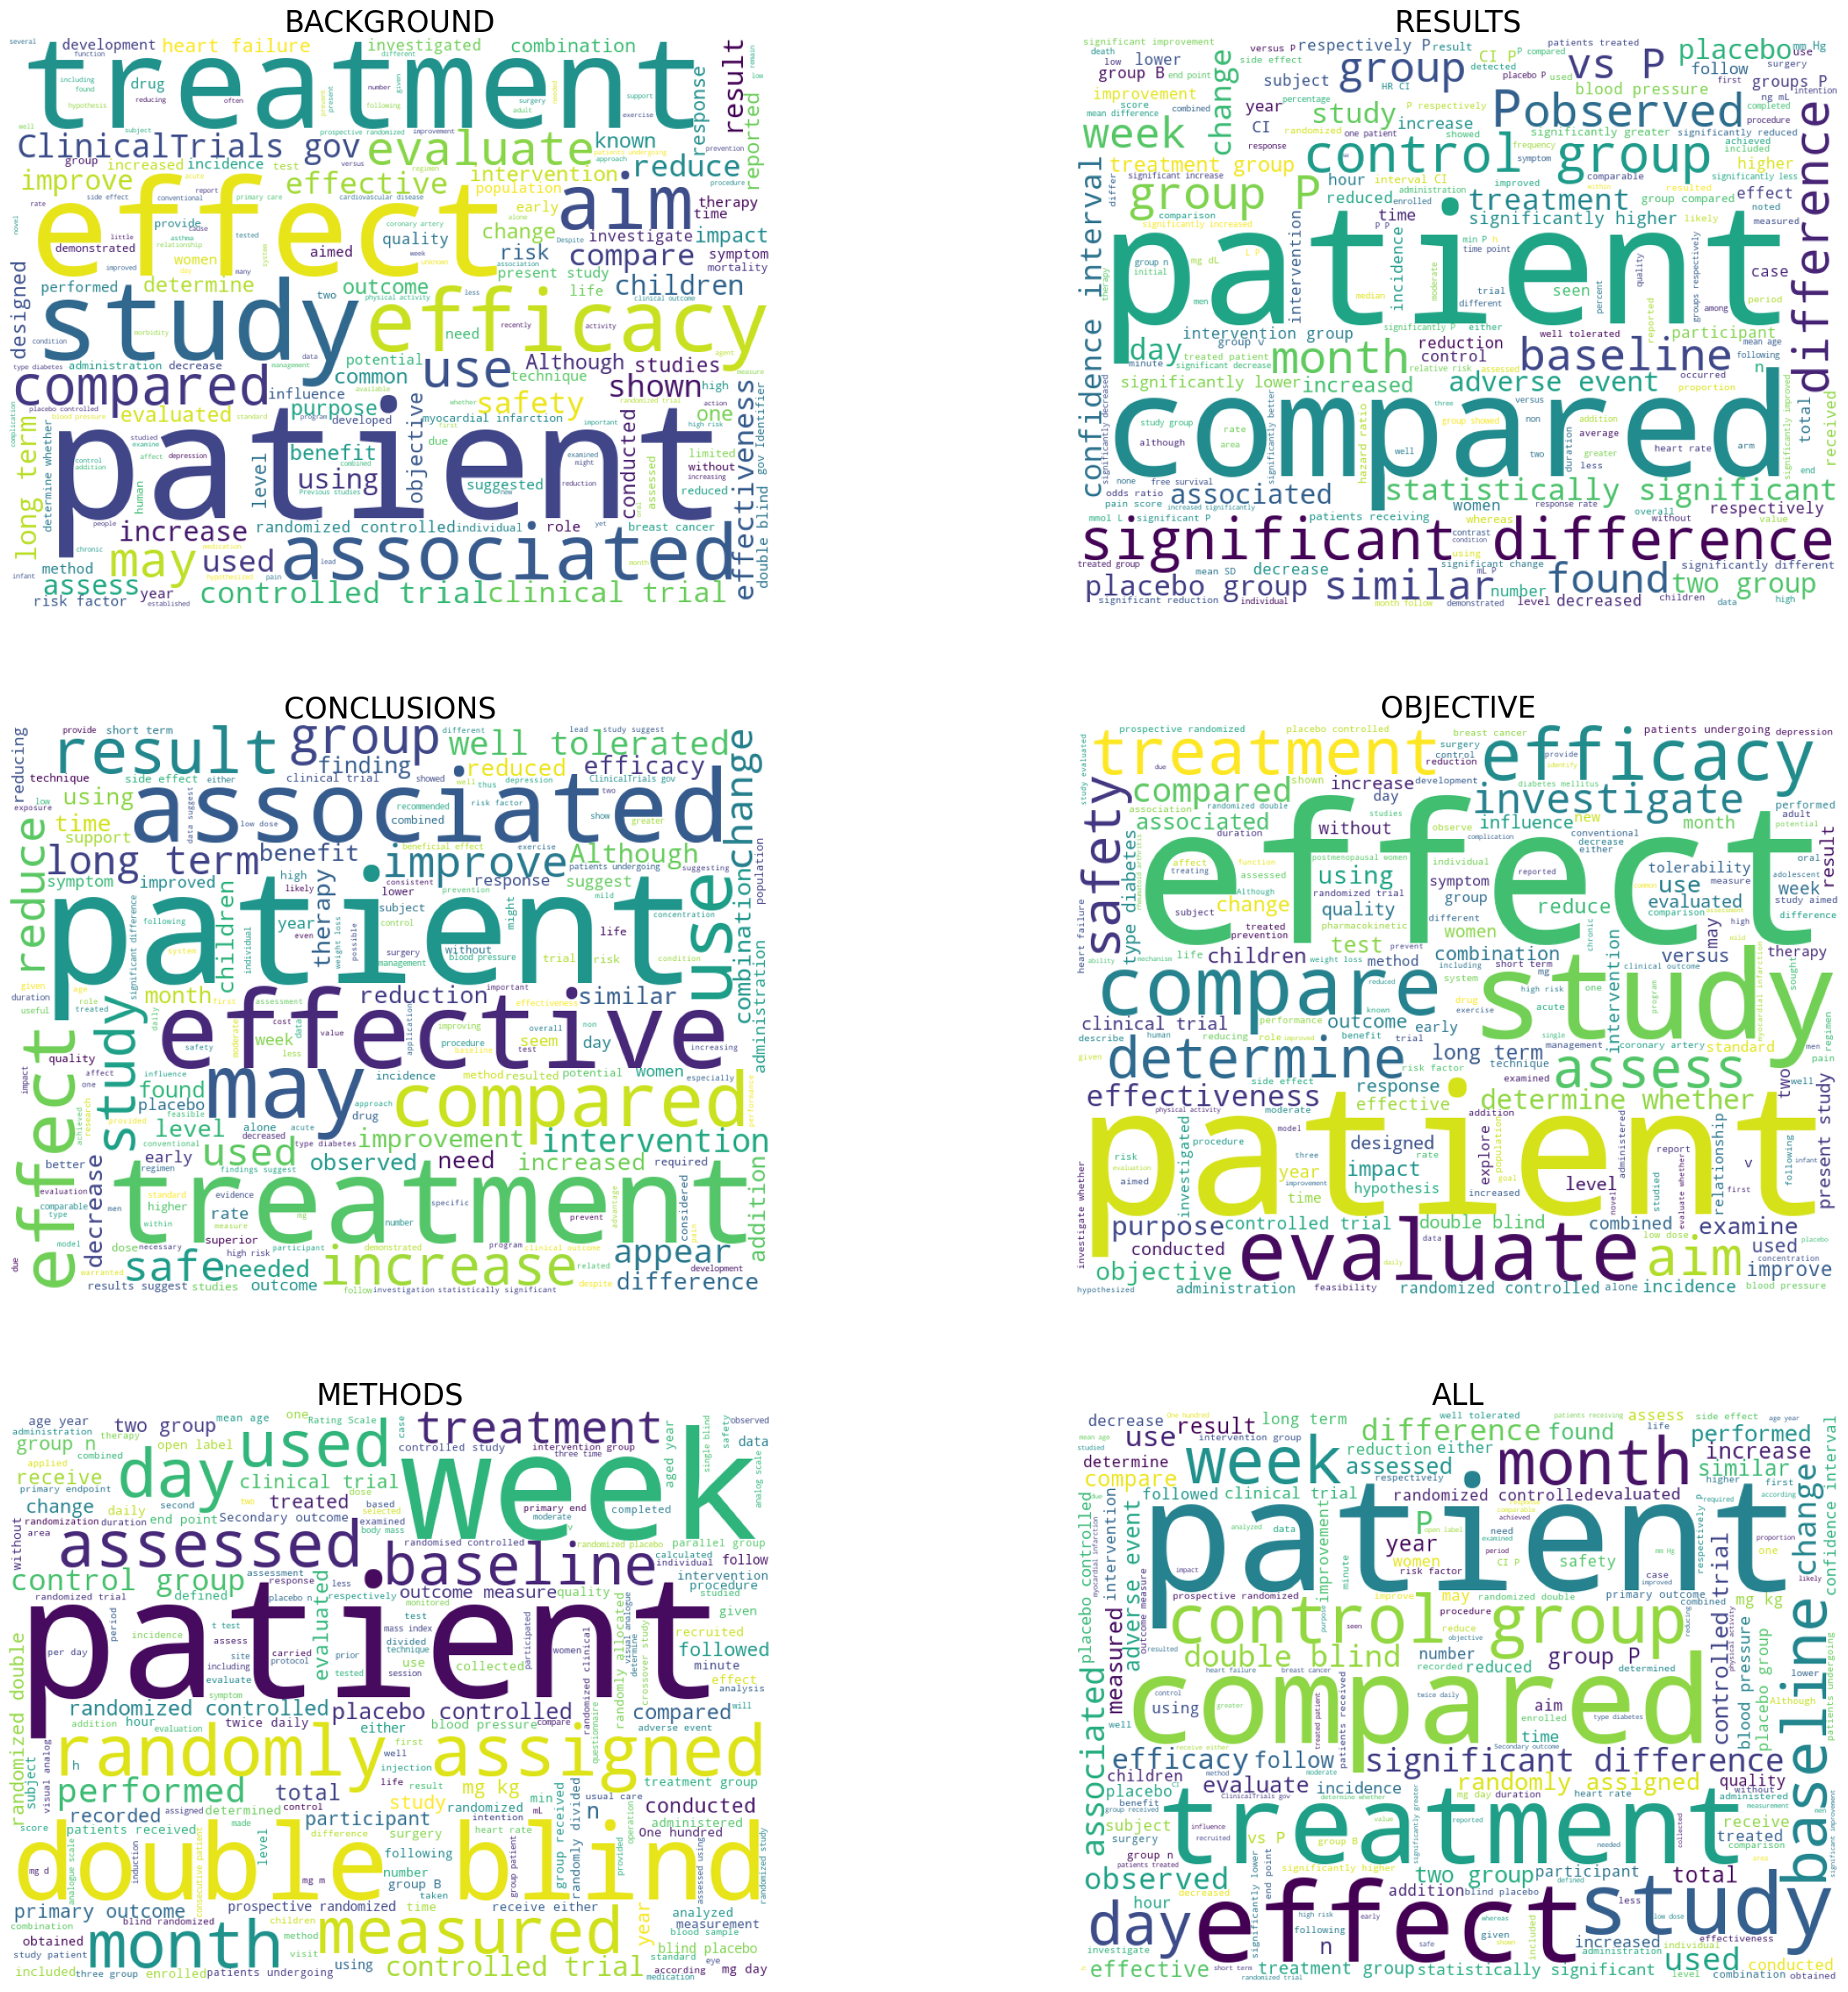

In [56]:
fig, axes = plt.subplots(3,2, figsize=(30, 30))

ax = axes.ravel()

groups = pubmed_df.label.unique().tolist() + ['ALL']

for i, label in enumerate(groups):
    if label != 'ALL':
        text = ' '.join(pubmed_df.sentence[pubmed_df.label==label])
        wordcloud = WordCloud(width = 800, height = 600, stopwords=STOPWORDS, background_color="white").generate(text)
        ax[i].imshow(wordcloud)
        ax[i].set_title(label, fontsize=25)
        ax[i].axis('off')
    else:
        text = ' '.join(pubmed_df.sentence)
        wordcloud = WordCloud(width = 800, height = 600, stopwords=STOPWORDS, background_color="white").generate(text)
        ax[i].imshow(wordcloud)
        ax[i].set_title(label, fontsize=25)
        ax[i].axis('off')

plt.show()